<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Онлайн-магазин «Викишоп» запускает новый сервис, который позволяет пользователям редактировать и дополнять описания товаров, аналогично вики-сообществам. Этот подход способствует увеличению вовлеченности пользователей и лучшему пониманию продуктов. Однако, с другой стороны, это может привести к появлению токсичных комментариев. В связи с этим, «Викишоп» нуждается в инструменте, способном отслеживать такие токсичные комментарии и отправлять их на модерацию.

**Цели проекта**

В этом проекте мы создадим и обучим модель машинного обучения, которая будет классифицировать комментарии пользователей на позитивные и негативные. Цель - достичь значения метрики качества F1 не менее 0.75.

**Методология**

Мы начнем с загрузки и подготовки данных, что включает в себя очистку и предварительную обработку текста комментариев. Затем мы обучим несколько моделей, используя различные алгоритмы машинного обучения, и выберем наиболее эффективную модель. В заключение, мы оценим результаты и сделаем выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Загрузка и подготовка данных

Импортируем необходимые библиотеки и загрузим данные из CSV-файла:

In [1]:
# Установка пакетов (при необходимости)
# !pip install wordcloud
# !pip install spacy
# !python -m spacy download en_core_web_sm

In [2]:
import re

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm
from lightgbm import LGBMClassifier
import spacy
from wordcloud import WordCloud





<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Совет:

    


    
- есть рекомендации PEP-8 при написании кода, в том числе и для импортов. Если интересно можешь почитать [тут](https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html). Есть что поправить 



<div class="alert alert-info">
<b>Комментарий студента</b>
    
Сгруппировала импорты согласно рекомендации PEP-8.
</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



Привет Ольга! Сейчас не вижу что можно подправить




</div>


In [3]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('toxic_comments.csv')
    
df.sample(10)

,Unnamed: 0,text,toxic
76278,76354,"To refer to your point Bjarki, I too was looki...",0
89299,89382,"Excuse me, but you already gave your opinion. ...",0
93575,93667,"""\n\n on pillaging \n\nHi Allen. I just read """,0
64759,64826,"Hello! \n\nHello! Please do NOT, edit my profi...",0
76915,76991,"""\nWere have i edited another users comments, ...",0
69002,69070,I would point you two the many times (includin...,0
141561,141714,I guess that's how it goes when someone has a ...,0
134477,134615,April 2006 (UTC)\n\n You allopaths took it upo...,0
27534,27571,Stay off. \n\nStay off my talk page. I removed...,0
11336,11349,That doesn't make the article less neutral.,0


<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Совет: 


Если не знаешь - чтобы не было столбца  `Unnamed: 0` при чтении файла можно так:


    pd.read_csv(..., index_col=0)

    
(`Unnamed: 0` появляется при не совсем корректном сохранении файла)    


Unnamed: 0 это "след" старых индексов. Если ты уберёшь первые 10 примеров и своего датасета, сохранишь его, а потом откроешь,  то появится столбец Unnamed: 0 начиная с цифры 9, и появится новый индексы начиная с нуля 


Но это мелочь,  даже не нужно ничего исправлять. Просто знай, чтобы увидев такое в чужом коде не удивляться что бы это могло означать

In [4]:
display(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


In [5]:
# Проверка на дубликаты
df.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

0    143106
1     16186
Name: toxic, dtype: int64

<AxesSubplot:>

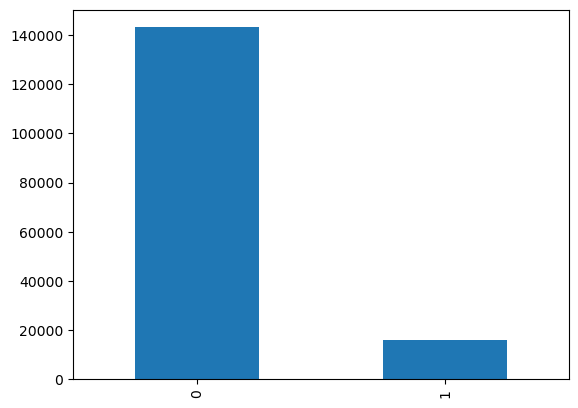

In [6]:
# Баланс классов в целевом признаке
display(df['toxic'].value_counts())
df['toxic'].value_counts().plot.bar()

Датасет содержит три столбца: 'Unnamed: 0', 'text' и 'toxic'. Столбец 'Unnamed: 0' представляет собой индекс и в данном случае не несет полезной информации, поэтому его можно удалить. Столбец 'text' содержит текст комментария, а 'toxic' — это целевой признак, где 1 означает токсичный комментарий, а 0 — не токсичный.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Данные изучены. Небольшой EDA не помешает, так как это аналитический проект. 


Плюс за

    

-  проверку на сбалансированность 



- Промежуточный вывод в конце раздела


<div class="alert alert-warning">

Совет: 




    
- .sample() вместо .head(), ведь если данные каким то образом упорядоченны, то шансы увидеть что то разнообразное через .sample чуть выше чем через .head (или .tail)     
   







<div class="alert alert-info">
<b>Комментарий студента</b>
    
Полезный совет, спасибо.
</div>

In [7]:
# Удалим признак, который нам не понадобится для обучения модели
df = df.drop('Unnamed: 0', axis=1)

Модели машинного обучения считают 'Word' и 'word' разными словами из-за разницы в регистре. Чтобы избежать этого, приведём все тексты к нижнему регистру.

In [8]:
df['text'] = df['text'].str.lower()

Используем функцию препроцессинга для проведения токенизации, лемматизации, очистки от символов и стоп-слов:

In [11]:
tqdm.pandas()

# Загрузка английского языка
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    # Очистка текста
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # Применение nlp, для токенизации, лемматизации и удаления стоп-слов
    doc = nlp(text)
    words = [token.lemma_ for token in doc if not token.is_stop]
    
    # Соединение слов обратно в текст
    text = " ".join(words)
    
    return text

# Применение функции к столбцу 'text'
df['text'] = df['text'].progress_apply(preprocess_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>

Ошибка:



- WordNetLemmatizer  рабочий вариант, но у него есть особенности, для корректной работы ему нужно передавать не просто слово, но и POS-тег (Part of Speech, части речи). Набираемся ума-разума [тут](https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/) )  Обрати внимание на функцию `get_wordnet_pos`. Сразу хочу предупредить, что если делать Лемматизацию правильно, сучетом постегов, то время может занять полчаса-час. Так что не удивляйся




<div class="alert alert-warning">


Совет: 



- здорово Что используешь apply, неэффективные циклы нам ни к чему, а еще лучше попробуй .progress_apply, делает что .apply, но еще и показывает на какой итерации находится.Для некоторых версий, чтобы заработал .progress_apply предварительно нужно сделать:
    
    
    from tqdm.notebook import tqdm
    tqdm.pandas()
    

И cудя по всему импорты нужно засунуть внутрь функции

То же самое делает .swifter.apply  Предварительно


    !pip install swifter
    import swifter


Если делаешь Colab и процесс лемматизации и очистки затягивается, попробуй  .parallel_apply,  кому-то это помогает уменьшить время прогона кода раз в 5-7. Предварительно: 


    
    from pandarallel import pandarallel   
    tqdm.pandas(desc="progress")
    pandarallel.initialize(progress_bar = True)




- лемматизацию можно было сделать с помощью SpaCy лемматизатором и прямо скажем как инструмент он более удобен и универсален, не нужно заморачиваться с токенизацией и учётом пос тегов

<div class="alert alert-info">
<b>Комментарий студента</b>
    
Спасибо за важные замечания. Обновила код с использованием SpaCy, добавила `tqdm` для отслеживания прогресса.
</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:


Есть лематизация! SpaCy отличный выбор, хотя конечно этих библиотек множество




</div>


In [12]:
display(df.head())
display(df.shape)

,text,toxic
0,explanation edit username hardcore metallica f...,0
1,d aww match background colour m seemingly st...,0
2,hey man m try edit war s guy constantly re...,0
3,t real suggestion improvement wonder sec...,0
4,sir hero chance remember page s,0


(159292, 2)

Визуализируем часто встречающиеся слова в текстовом корпусе токсичных и нетоксичных комментариев при помощи "облака слов" (библиотеки Word Cloud). Сравнивая облака слов для комментариев, мы можем наблюдать различия в часто используемых словах и возможно выявить некоторые ключевые слова или фразы, которые характерны для токсичных комментариев.

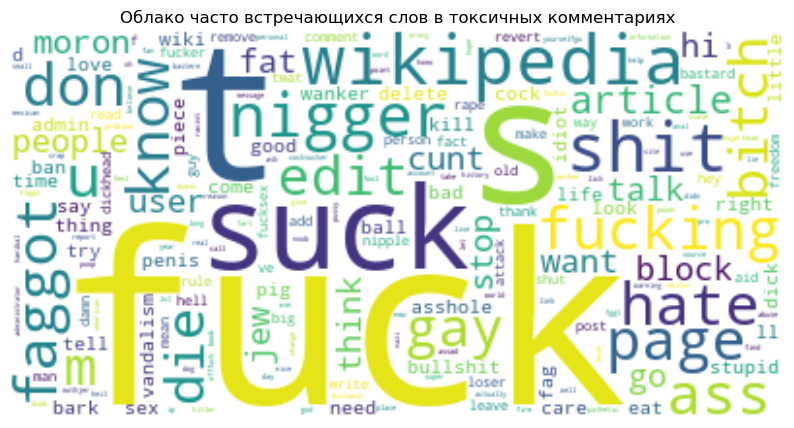

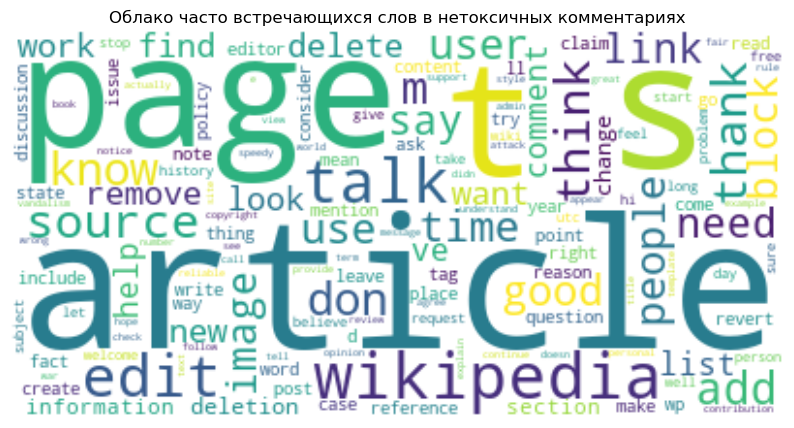

In [13]:
def create_wordcloud(comments, title):
    # Преобразуем все комментарии в одну строку
    text = " ".join(comment for comment in comments)
    
    # Создаем облако слов
    wordcloud = WordCloud(background_color='white', collocations=False).generate(text)
    
    # Визуализируем облако слов
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Отберем только токсичные комментарии
toxic_comments = df[df['toxic'] == 1]['text']
create_wordcloud(toxic_comments, 'Облако часто встречающихся слов в токсичных комментариях')

# Отберем только нетоксичные комментарии
non_toxic_comments = df[df['toxic'] == 0]['text']
create_wordcloud(non_toxic_comments, 'Облако часто встречающихся слов в нетоксичных комментариях')



<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:


Красиво, хотя слова некрасивые.  И как видишь есть дубликаты, можно посмотреть как их убрать collocations=False:    
    
https://stackoverflow.com/questions/43954114/python-wordcloud-repetitive-words





<div class="alert alert-info">
<b>Комментарий студента</b>
    
Обновила код, исключила сочетания слов.
</div>

Перед тем как применить векторизацию, разделим данные на обучающую и тестовую выборки в соотношении 80% к 20%. Это важно, так как векторизация (или любой другой вид преобразования данных) должна быть обучена только на обучающей выборке, чтобы избежать утечки данных.

У нас есть несбалансированные классы в целевом признаке, поэтому добавим параметр 'stratify', гарантирующий, что в обучающей и тестовой выборке будет примерно одинаковое соотношение токсичных и нетоксичных комментариев, что поможет предотвратить смещение в обучении и оценке модели.

In [14]:
X = df['text']
y = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df['toxic'], random_state=42)

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


- random_state на месте


- правильно разбито на 2 выборки (иногда студенты использующие GS разбивают на 3 датасета)



- здорово что используешь stratify    



In [15]:
# Проведем векторизацию текстов
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


Не забыли о стопсловах, они ни к чему и код побежит быстрей

    
<div class="alert alert-warning">


Совет:     

Вопросик:

А стопслова важней убирать  когда мы используем TF-IDF, или когда используе обычный CountVectorizer? 



<div class="alert alert-info">
<b>Комментарий студента</b>
    
Я считаю, что важно удалять стоп-слова как при использовании CountVectorizer, так и TfidfVectorizer. Поскольку стоп-слова, включающие в себя предлоги, союзы, местоимения и другие, обычно не несут значимой семантической информации, их присутствие может искажать общее представление о ключевых словах в тексте.
</div>



<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюераV2</b></font>

Совет: 


Без сомнения убирать нужно в обоих случая. А это был вопрос на понимание: Стоп слова это частые и "бессмысленные" слова, а TF-IDF делает вес частых слов ниже, то есть он и так стопслова "обесценивает". Вот и получается что для CountVectorizer убрать стопслова важней чем для  TF-IDF
</div>

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Совет:


- .fit_transform на train датасете, .transform на test/valid. Вроде все верно, но после ты подаешь tf_idf_train в GridSearchCV или cross_val_score и он внутри себя разбивая его на тренировочный и валидационный датасет, получается подглядывание в будущее (утечка данных). Решение в использовании pipeline, ниже распишу
    
    
    


</div>


In [16]:
print("Размерность вектора для обучающей выборки:", X_train_vectorized.shape)
print("Размерность вектора для тестовой выборки:", X_test_vectorized.shape)

Размерность вектора для обучающей выборки: (127433, 131995)
Размерность вектора для тестовой выборки: (31859, 131995)


На данном этапе исследования мы провели предварительную обработку данных и подготовили их для построения моделей машинного обучения:

- **Удалили ненужные столбцы:** Мы убрали столбец 'Unnamed: 0', так как он не несет полезной информации для нашего анализа.

- **Провели препроцессинг текста:** Все тексты были приведены к нижнему регистру, а затем была проведена токенизация и лемматизация. Мы также удалили стоп-слова и символы, которые не несут смысловой нагрузки.

- **Визуализировали данные:** Мы создали облака слов для токсичных и нетоксичных комментариев, чтобы лучше понять, какие слова наиболее часто встречаются в каждом из классов.

- **Разбили данные на обучающую и тестовую выборки:** Данные были разделены на обучающую и тестовую выборки с помощью train_test_split.

- **Преобразовали текст в векторы:** Мы применили TF-IDF векторизацию к нашим текстовым данным, чтобы преобразовать их в формат, который можно использовать для обучения модели машинного обучения.

мы успешно подготовили наши данные для последующего обучения моделей. Далее мы будем выбирать и обучать модели машинного обучения, чтобы классифицировать комментарии на токсичные и нетоксичные.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



Промежуточный вывод всегда в тему




</div>


## Обучение

In [17]:
def best_model_random_search(X_train, y_train):
    # Сетка параметров для каждой модели
    model_params = {        
        'logistic_regression': {
            'model': LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'),
            'params': {
                'C': [0.001, 0.01, 0.1, 1, 10, 100]
            }
        },
        'decision_tree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'max_depth': [5, 10, 15, 20, None],
                'min_samples_leaf': [1, 2]
            }
        },
        'lgbm': {
            'model': LGBMClassifier(random_state=42),
            'params': {
                'num_leaves': [7, 14, 31],
                'max_depth': [3, 4, 5, -1],
                'learning_rate': [0.1, 0.03],
                'n_estimators': [50, 100]
            }
        }
    }
    
    scorer = make_scorer(f1_score)
    best_models = []
    
    # Перебор моделей и их параметров
    for model_name, mp in model_params.items():
        clf = RandomizedSearchCV(mp['model'], mp['params'], scoring=scorer, cv=3, n_jobs=-1, n_iter=10)
        clf.fit(X_train, y_train)
        print(f"Модель: {model_name}")
        print("Лучшие параметры: ", clf.best_params_)
        print("Лучший F1-счет: ", clf.best_score_)
        best_models.append({
            'model': model_name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_
        })
        
    return pd.DataFrame(best_models, columns=['model', 'best_score', 'best_params'])

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Корректно использован GridSearch  (есть и другие варианты, тюнинга гиперпараметров, можешь [ознакомиться](https://www.freecodecamp.org/news/hyperparameter-optimization-techniques-machine-learning/))

- не забыт random_state


- class_weight = 'balanced'


- scoring = 'f1'


 


    

<div class="alert alert-warning">

Совет: 




Молодец что используешь GridSearch, но еще лучше использовать связку GridSearchCV + pipeline. 


О pipeline:

[Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), это тема которая сразу затрагивает кроссвалидацию, тюнинг "векторайз", подбор гиперпараметров модели и о том что код стоит делать компактным.
    
    
- в TfidfVectorizer(stop_words=stopwords) у тебя по умолчанию ngram_range=(1, 1), тут можно подбирать разное число n- грамм (и другие параметры), максимизируя метрику, но как объединить перебор по ngram_range с обучением моделей, чтобы не делать это по отдельности или с использованием цикла?! pipeline! Готовый [пример для работы с текстами](https://medium.com/@yoni.levine/how-to-grid-search-with-a-pipeline-93147835d916). Всё что нужно там есть, хотя очень лаконично. Можешь погуглить по:


    
    pipeline nlp gridsearchcv



- как избежать ошибки подглядывания в будущее, когда мы предварительно работаем с данными (шкалирование, нормализация, TfidfVectorizer итп итд)? pipeline! особенно это важно, когда мы используем кроссвалидацию. Для TfidfVectorizer делаем .fit (обучаемся) на train, а transform на test, но точно также нужно сделать для валидационной выборки. Но GS делает валидационные внутри себя, спрашивается как добраться до нее и избежать подглядывания в будущее? Казалось бы никак, но нет! Pipeline! ) 
    
    
- pipeline позволяет делать наш код компактней и читабельней, это большой плюс, когда код будет раздуваться     
    
    

         
Если раньше не использовала pipeline то могу посоветовать видео в котором [индус](https://www.youtube.com/watch?v=mOYJCR0IDk8&ab_channel=HimanshuChandra) на английском с сильным акцентом, но на пальцах обьясняет  самое непонятное (по моему опыту): сопряженность методов fit и transform. Там же есть и код и ссылка на текст. Мне помогло )



В общем если сделать GS+pipeline будет вообще хорошо )  
    
<div>   

In [18]:
best_model_results = best_model_random_search(X_train_vectorized, y_train)
best_model_results

c:\Users\olean\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Модель: logistic_regression
Лучшие параметры:  {'C': 10}
Лучший F1-счет:  0.7633837793462964
Модель: decision_tree
Лучшие параметры:  {'min_samples_leaf': 1, 'max_depth': None}
Лучший F1-счет:  0.7161858067931562
Модель: lgbm
Лучшие параметры:  {'num_leaves': 31, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.1}
Лучший F1-счет:  0.7476776192823529


,model,best_score,best_params
0,logistic_regression,0.763384,{'C': 10}
1,decision_tree,0.716186,"{'min_samples_leaf': 1, 'max_depth': None}"
2,lgbm,0.747678,"{'num_leaves': 31, 'n_estimators': 100, 'max_d..."


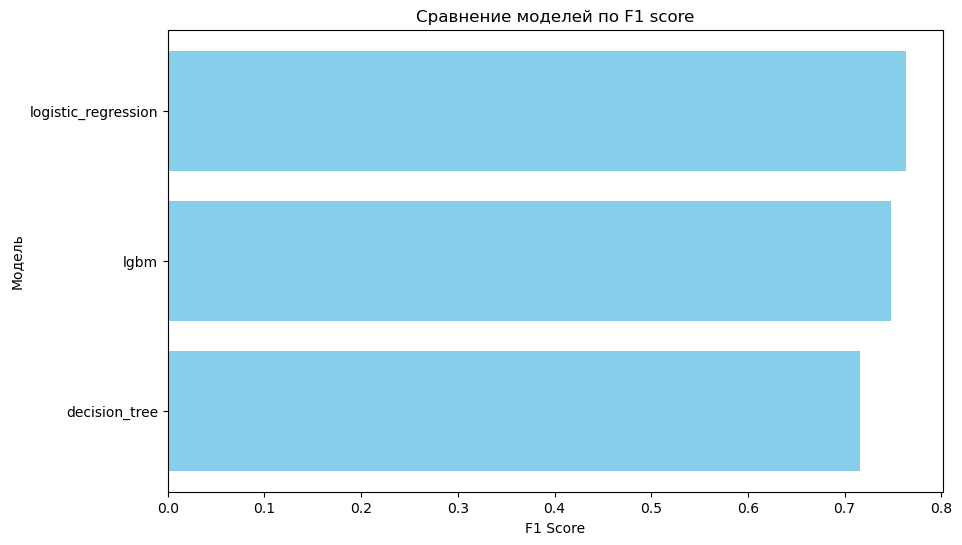

In [19]:
results_df = best_model_results.sort_values('best_score')

plt.figure(figsize=(10, 6))
plt.barh(results_df['model'], results_df['best_score'], color='skyblue')

plt.title('Сравнение моделей по F1 score')
plt.xlabel('F1 Score')
plt.ylabel('Модель')
plt.show()

Мы успешно провели поиск по сетке для выбора лучших гиперпараметров для каждой из выбранных моделей. По результатам поиска, модель логистической регрессии (logistic_regression) показала наилучший результат по метрике F1 (0.763384), с оптимальным значением гиперпараметра 'C' равным 10. Проверим качество нашей лучшей модели на тестовом наборе данных.

In [21]:
# Обучение модели на обучающей выборке
best_model = LogisticRegression(C=10, random_state=42, solver='liblinear', class_weight='balanced')
best_model.fit(X_train_vectorized, y_train)

# Применение модели к тестовым данным
y_test_pred = best_model.predict(X_test_vectorized)

# Вычисление метрики F1
f1 = f1_score(y_test, y_test_pred)

print(f"F1 score на тестовой выборке: {f1}")

F1 score на тестовой выборке: 0.7631767916128106





<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюераV2</b></font>
    
    
Совет:



    


Не надо воспринимать  GS как способ получить .best_params_, чтобы подставить их в модель и обучить на них. GS это сделал уже и модельку положил тут: .best_estimator_
    
  
То есть вот это не нужно    
    
    best_model = LogisticRegression(C=10, random_state=42, solver='liblinear', class_weight='balanced')
    best_model.fit(X_train_vectorized, y_train)


    
    
Всё уже за нас сделано    

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка ❌:




А в чём смысл обучить на тестовой? Вспомни проект "ведение в машинное обучение" и то как мы там использовали тестовый выборку

<div class="alert alert-info">
<b>Комментарий студента</b>
    
Конечно, это нарушает основной принцип разделения данных на обучающую и тестовую выборки. Мы должны использовать обучающую выборку для обучения модели, а затем применить обученную модель к тестовым данным для оценки ее производительности. Код исправлен.
</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



Метрика стала скромнее, но это истинная оценка нашей модели




</div>


Наша модель показала хороший результат F1-меры на тестовой выборке, что указывает на её высокую эффективность в предсказании целевой переменной. Это значит, что модель правильно классифицирует 76,3% случаев, что является неплохим результатом.

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Совет: 


Альтернатива твоему подходу это использовать Берт.  В чём преимущество?!


TF-IDF просто считает количество того или иного слов в предложении. Так он переводит текст, который непонятен компьютеру, в числа. Но можно ведь сделать посложнее, и в качестве слова взять вектор, причём так что вектор слово "мужчина" и вектор слова "человек" были близки - то есть тут уже учитывается внутренняя материя языка. Или например известный пример: создаем такие вектора слов, что если от вектора слова "король", отнять Вектор слова "мужчина" и добавить Вектор слова "женщина", то получится Вектор близкий к вектору слова "Королева".  Это можно получить с помощью Word2Vec. Но на самом деле эмбединги (вектора) слов от Берта и подобных ему моделей (Называются модели с Улицы Сезам) еще круче, потому что они ещё и учитывают контекст слова, то есть он работает с целым предложением, и теперь эмбединг одного и того же слова может отличаться в зависимости от того в каком предложении (контексте) он стоит. 


Как мы можем использовать Берт?  Можем его использовать чтобы получить эмбединги и подать их в наши модели как альтернативу векторов от TFIDF/CountVectorizer (чтобы это реализовать можно взять готовый код в тренажёре). Можно усложнить и потюнить модель Берта под наш датасет. Можешь взять на основу этот [ролик](https://www.youtube.com/watch?v=Z1J3sTJYIcc&list=PLEwK9wdS5g0qksxWxtE5c2KuFkIfUXe3i&index=14), там прямо можно посмотреть процесс кодирования, и получше разобраться в практической релизации Берта.  А можно сделать проще, использовав уже готовые [модели](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html) которые предсказывают токсичный текст на английском или нет. Можешь попробовать для пробы:



    model_path = "martin-ha/toxic-comment-model"
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    pipeline =  TextClassificationPipeline(model=model, tokenizer=tokenizer)


    test_bert = test.sample(1000, weights='toxic', random_state=123)


    y_pred = []
    for text in tqdm(test_bert['text']):
        # print(text)
        pred = pipeline(text[:512])
        y_pred.append(1 if pred[0]['label'] == 'toxic' else 0)



Я взял этот код у студента, который  без всякого обучения получил таким образом  метрику 0,765. Это для оценки того насколько мощные модели с "Улицы Сезам"

## Выводы

В ходе данного проекта была проведена подготовка и анализ данных для обучения моделей, способных классифицировать комментарии на позитивные и негативные.

Были рассмотрены три различные модели машинного обучения: Logistic Regression, Decision Tree и LGBM. Для каждой из них были подобраны наилучшие гиперпараметры с использованием метода случайного поиска.

По итогу лучший результат на обучающей выборке показала модель Logistic Regression с гиперпараметром C равным 10. Значение F1-меры составило 0.763.

При проверке этой модели на тестовой выборке, F1-мера практически не изменилась и составила 0.763. Это подтверждает, что модель обладает высокой предсказательной способностью и является хорошим выбором для данной задачи классификации.

В целом, проект демонстрирует, как можно применять методы обработки текста и машинного обучения для анализа отзывов клиентов и предсказания негативных отзывов. Однако, необходимо помнить, что результаты могут варьироваться в зависимости от конкретного набора данных и специфики задачи.


<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>



Ольга, у тебя старательно выполненная работа, все четко, осмысленно. 


GS использован корректно. Если хочешь прокачать свой скилл попробуй использовать его с pipeline. 


А ещё можешь попробовать очень современный и модный сейчас подход с использованием эмбедингов от Берт (в этом случае разрешается сильно порезать датасет, а если еще и использовать GPU в Colab код можно прогнать за полчаса).

    
    

Я оставил небольшие советы и вопросики (если есть время и желание можешь воспользоваться/ответить).
    



Обязательное к исправлению:






- WordNetLemmatizer используем с POS - тег 

    
    
- к финальному тестированию подходим с уже готовой, обученной моделью, на тестовой выборке ничего не обучаем, на тестовой выборке ничего не валидируем, на тестовой выборке не подбираем порога. На тестовой выборке только делаем прогноз


    
    
    
Жду исправлений, для принятия проекта. Если какие то вопросы, то сразу спрашивай ) 


<font color='green'><b>Полезные (и просто интересные) материалы:</b> \
Для работы с текстами используют и другие подходы. Например, сейчас активно используются RNN (LSTM) и трансформеры (BERT и другие с улицы Сезам, например, ELMO). НО! Они не являются панацеей, не всегда они нужны, так как и TF-IDF или Word2Vec + модели из классического ML тоже могут справляться. \
BERT тяжелый, существует много его вариаций для разных задач, есть готовые модели, есть надстройки над библиотекой transformers. Если, обучать BERT на GPU (можно в Google Colab или Kaggle), то должно быть побыстрее.\
https://huggingface.co/transformers/model_doc/bert.html \
https://t.me/renat_alimbekov \
https://colah.github.io/posts/2015-08-Understanding-LSTMs/ - Про LSTM \
https://web.stanford.edu/~jurafsky/slp3/10.pdf - про энкодер-декодер модели, этеншены\
https://pytorch.org/tutorials/beginner/transformer_tutorial.html - официальный гайд
по трансформеру от создателей pytorch\
https://transformer.huggingface.co/ - поболтать с трансформером \
Библиотеки: allennlp, fairseq, transformers, tensorflow-text — множествореализованных
методов для трансформеров методов NLP \
Word2Vec https://radimrehurek.com/gensim/models/word2vec.html 


Если понравилась работа с текстами, то можешь посмотреть очень интересный (но очень-очень сложный) курс лекций: https://github.com/yandexdataschool/nlp_course .

Если нравится смотреть и слушать то есть целый курс на Ютубе https://www.youtube.com/watch?v=qDMwIQRQt-M&list=PLEwK9wdS5g0qksxWxtE5c2KuFkIfUXe3i&index=1


<div class="alert alert-info">
<b>Комментарий студента</b>
    
Марат, спасибо за твое подробное ревью моего проекта, и полезные рекомендации и материалы для изучения.
</div>


<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Спасибо за работу!

Красное исправлено,  желтые советы использованы, на  вопросы есть ответы  (это все было по желанию), значит стремишься развиваться, а желание и интерес это главное. Надеюсь мои советы и вопросики были полезны и в копилочку знаний упало что то новое, а проект стал лучше, и симпатичней.


  
Отличная работа Ольга. Желаю успехов в дальнейшей учебе!


 Вообще именно в НЛП сейчас самые большие прорывы в машинном обучении,  может в курсе про [chatGPT](https://www.youtube.com/watch?v=IMP1zZ9K4Wc&t=3038s), GPT - это братик Берта )

   

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны